# REGRESSAO LOGISTICA

In [100]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
import scipy.stats as stats
import warnings

In [101]:
#df = pd.read_csv('08notsmote_FEAUTURES.csv')
df = pd.read_csv('10ma_FEAUTURES.csv')
df.head()

,pEffort,uaI,SleepInd,Sex_F,pEffort(MA6),SleepInd(MA6),uaI(MA6),Appetite(MA6),FatigInd
0,6.0,2.08,-5.00,1,4.678341,-4.713350,2.252252,5.297907,Optimal
1,1.0,2.00,-6.53,1,4.206534,-6.136979,1.997465,6.000013,Optimal
2,1.0,0.00,-4.00,0,3.712435,-3.576147,1.099577,4.884461,Optimal
3,5.0,2.69,-6.00,1,4.685066,-5.692758,2.201203,6.000000,Optimal
4,7.0,2.03,-5.00,1,6.853002,-5.523600,1.905526,6.028801,Optimal


In [102]:
X = df.drop(columns=["FatigInd"])
y = df["FatigInd"]

# standartizar os dados e separar treino de teste

In [103]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=346752)
X_train.shape, X_test.shape

((511, 8), (128, 8))

## modelo base

In [104]:
warnings.filterwarnings("ignore")

# Define the model
model = LogisticRegression(max_iter=10000)

# Define the hyperparameter distribution
param_dist = {
    'penalty': ["l1", "l2", None],
    'C': stats.uniform(0.01, 300),  # Continuous range for C
    'solver': ['saga'],  # Continuous range for l1_ratio
    'class_weight': [
        {"Low/Minimal": .9, "Optimal": 1, "Risk/Caution": .9},
        {"Low/Minimal": 1, "Optimal": 1.05, "Risk/Caution": 1},
        {"Low/Minimal": 1, "Optimal": 1.1, "Risk/Caution": 1},
        {"Low/Minimal": 0, "Optimal": .5, "Risk/Caution": 0},  # Another alternative
        None,  # No class weights
    ],  # Class weights for balancing
}

# Perform Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_dist, # Hyperparameter distribution
                                   n_iter=100, # iterations 
                                   cv=9, # cross-validation
                                   scoring='accuracy', # metric
                                   random_state=21) # seed
random_search.fit(X_train, y_train)

# Results
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

Best Parameters: {'C': np.float64(209.3118957617281), 'class_weight': {'Low/Minimal': 1, 'Optimal': 1.05, 'Risk/Caution': 1}, 'penalty': None, 'solver': 'saga'}
Best Cross-Validation Score: 0.6164369256474519


In [105]:
""" GRAFICO DO MELHOR C
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


# Define the range for hyperparameters
C = np.logspace(-2.5, 2, num=1000) #np.arange(0.001, 100, 0.1)
a = []
acc = []

# Loop over C and l1_ratio to calculate cross-validation scores
for c in C:
    model = LogisticRegression(C=c, penalty="l1", max_iter=1000, solver='saga')
    scores = cross_val_score(model, X_train, y_train, cv=7, scoring='accuracy')
    a.append(scores.mean())
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    acc.append(test_accuracy)
    

# Plot the 2D topographic map using contour
plt.figure(figsize=(10, 8))

plt.plot(C, a, label="cross-validation score")
plt.plot(C, acc, label="accuracy dados de test")
plt.legend()

# Add labels and title
plt.xlabel('C')
plt.ylabel('scores')
plt.xscale('log')

plt.show()
"""

' GRAFICO DO MELHOR C\nimport matplotlib.pyplot as plt\nimport numpy as np\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.model_selection import cross_val_score\nfrom sklearn.metrics import accuracy_score\n\n\n# Define the range for hyperparameters\nC = np.logspace(-2.5, 2, num=1000) #np.arange(0.001, 100, 0.1)\na = []\nacc = []\n\n# Loop over C and l1_ratio to calculate cross-validation scores\nfor c in C:\n    model = LogisticRegression(C=c, penalty="l1", max_iter=1000, solver=\'saga\')\n    scores = cross_val_score(model, X_train, y_train, cv=7, scoring=\'accuracy\')\n    a.append(scores.mean())\n    model.fit(X_train, y_train)\n\n    y_pred = model.predict(X_test)\n    test_accuracy = accuracy_score(y_test, y_pred)\n    acc.append(test_accuracy)\n    \n\n# Plot the 2D topographic map using contour\nplt.figure(figsize=(10, 8))\n\nplt.plot(C, a, label="cross-validation score")\nplt.plot(C, acc, label="accuracy dados de test")\nplt.legend()\n\n# Add labels and titl

In [106]:
best_model = random_search.best_estimator_

/opt/anaconda3/envs/FAA/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/FAA/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/FAA/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/FAA/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/FAA/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/FAA/lib/python3.10/site-packages/sklearn/linear_mo

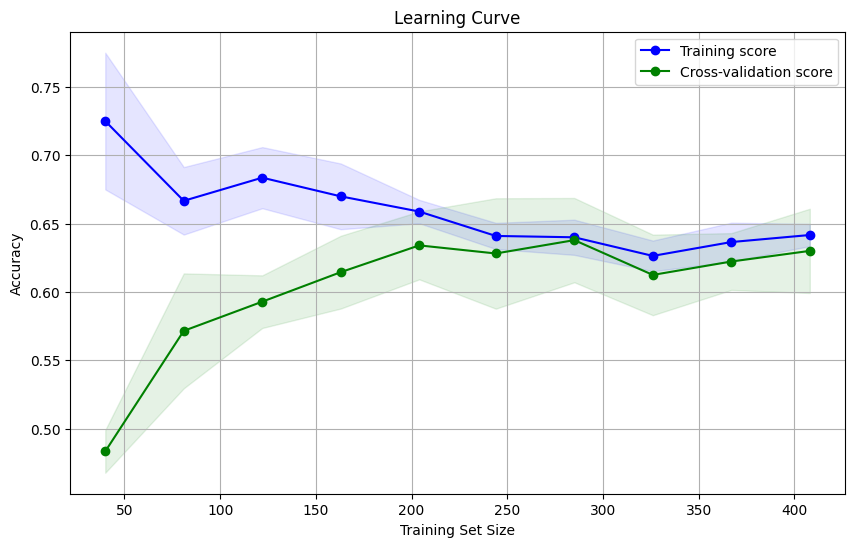

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and std for plotting
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Training score", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.plot(train_sizes, test_mean, 'o-', label="Cross-validation score", color="green")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="green")
#plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("7-Fold Cross-Validation Accuracy")
#plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.ylim(0.3, 1.0)
plt.grid()
plt.show()


# medidas de avaliacao

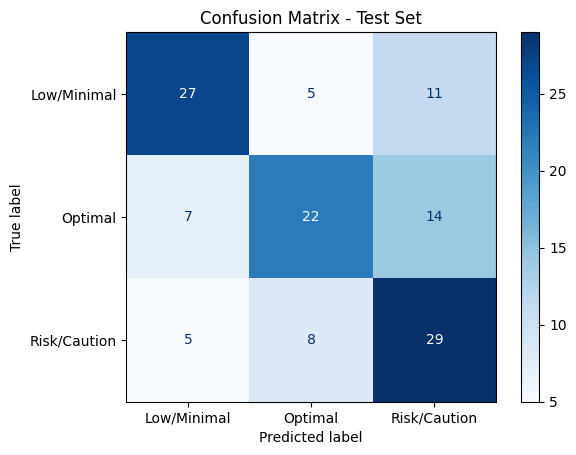

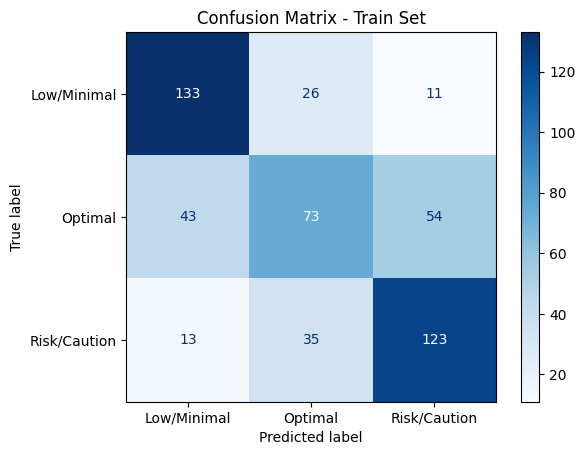

In [108]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming X (features) and y (labels) are defined elsewhere in your code

# Split the data into train and test sets

# Fit the model to the training data
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = best_model.predict(X_test)

# Generate the confusion matrix for the test set
cm_test = confusion_matrix(y_test, y_pred_test)

# Display the confusion matrix for the test set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=best_model.classes_)
disp_test.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

# Optionally, you can also generate confusion matrix for the training set
y_pred_train = best_model.predict(X_train)

# Generate the confusion matrix for the train set
cm_train = confusion_matrix(y_train, y_pred_train)

# Display the confusion matrix for the train set
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=best_model.classes_)
disp_train.plot(cmap="Blues")
plt.title("Confusion Matrix - Train Set")
plt.show()


In [109]:
from sklearn.metrics import classification_report

y_pred_test = best_model.predict(X_test)
report = classification_report(y_test, y_pred_test)
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

 Low/Minimal       0.69      0.63      0.66        43
     Optimal       0.63      0.51      0.56        43
Risk/Caution       0.54      0.69      0.60        42

    accuracy                           0.61       128
   macro avg       0.62      0.61      0.61       128
weighted avg       0.62      0.61      0.61       128



In [110]:
y_pred_train = best_model.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

 Low/Minimal       0.70      0.78      0.74       170
     Optimal       0.54      0.43      0.48       170
Risk/Caution       0.65      0.72      0.69       171

    accuracy                           0.64       511
   macro avg       0.63      0.64      0.64       511
weighted avg       0.63      0.64      0.64       511

